In [1]:
# 데이터 불러오기
import pandas as pd
import numpy as np

file_path = 'dataset/HR_Employee.csv'
data = pd.read_csv(file_path)

data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [6]:
# class 불균형 해결 - oversampling

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# 범주형 변수 One-Hot Encoding
X = pd.get_dummies(data.drop(columns=['Attrition']), drop_first=True)

y = data['Attrition']

# Label Encoding
le = LabelEncoder()
y = le.fit_transform(y)

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("After SMOTE Resampling:")
print(pd.Series(y_resampled).value_counts())

After SMOTE Resampling:
1    1233
0    1233
Name: count, dtype: int64


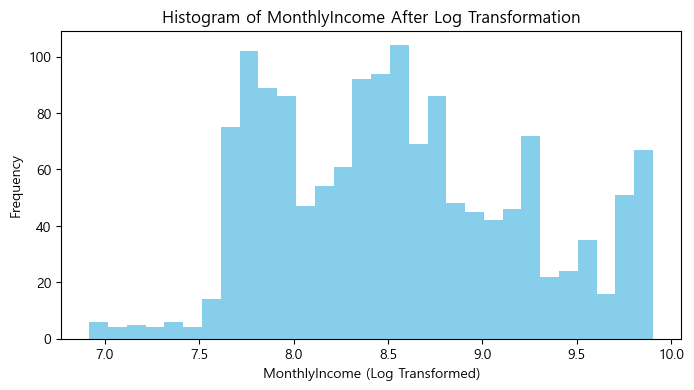

In [10]:
# 이상치 처리 - MonthlyIncome, 격차를 줄이기 위해서 log 함수 활용

data['MonthlyIncome_Log'] = np.log1p(data['MonthlyIncome'])

In [12]:
# 이상치 처리하여 변수명이 변경되었으므로 불필요한 변수 제거 
## data_cleaned 
columns_to_drop = ['MonthlyIncome']
data_cleaned = data.drop(columns=columns_to_drop)

Columns after removal:
Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'MonthlyIncome_Log'],
      dtype='object')


Data shape after removing outliers: (1092, 35)


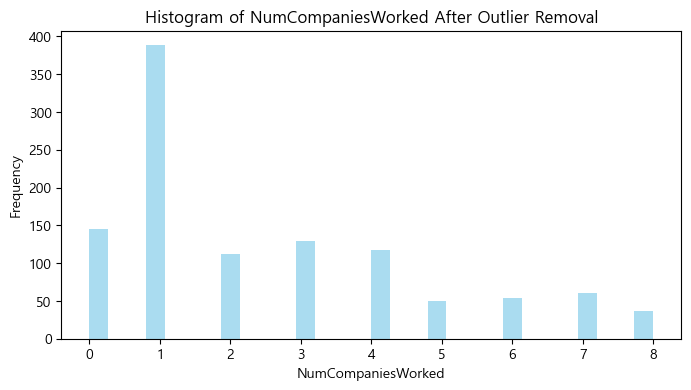

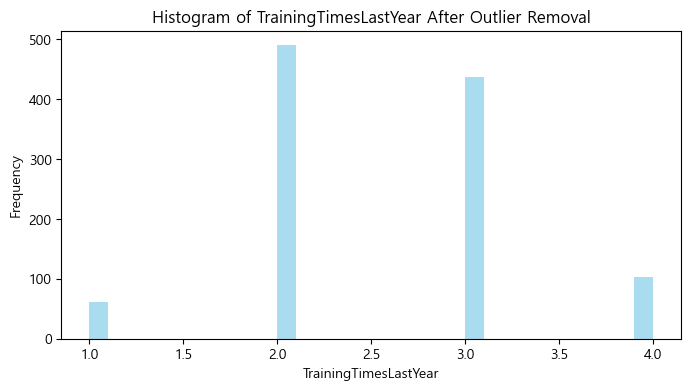

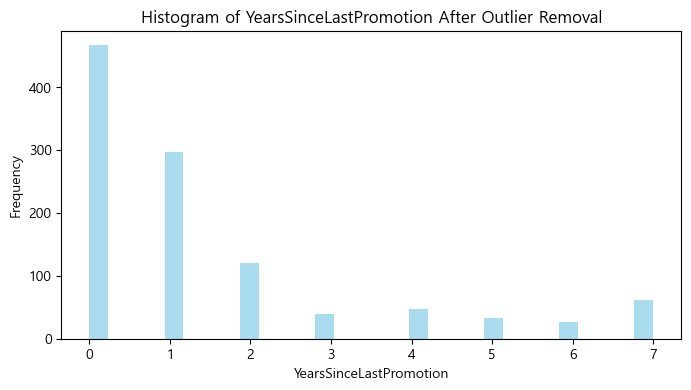

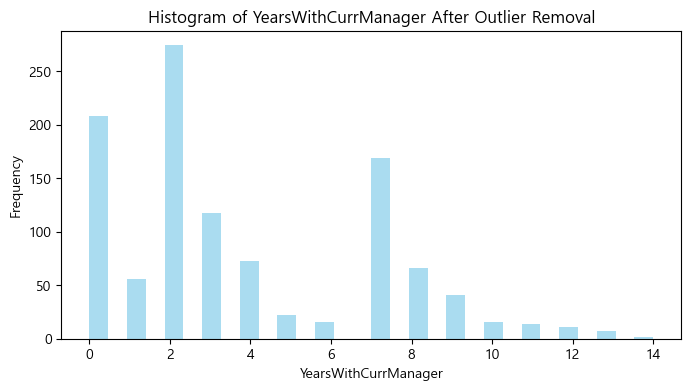

In [13]:
# 이상치 처리 - NumCompaniesWorked, TrainingTimesLastYear, YearsSinceLastPromotion, YearsWithCurrManager
variables_to_process = ['NumCompaniesWorked', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

for feature in variables_to_process:
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    data_cleaned = data_cleaned[(data_cleaned[feature] >= lower_bound) & (data_cleaned[feature] <= upper_bound)]

# 처리 후 데이터 크기 확인
print(f"Data shape after removing outliers: {data_cleaned.shape}")

In [14]:
# 불필요한 열 제거
data_cleaned = data_cleaned.drop(['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours'], axis=1)

data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1092 entries, 1 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1092 non-null   int64  
 1   Attrition                 1092 non-null   object 
 2   BusinessTravel            1092 non-null   object 
 3   DailyRate                 1092 non-null   int64  
 4   Department                1092 non-null   object 
 5   DistanceFromHome          1092 non-null   int64  
 6   Education                 1092 non-null   int64  
 7   EducationField            1092 non-null   object 
 8   EnvironmentSatisfaction   1092 non-null   int64  
 9   Gender                    1092 non-null   object 
 10  HourlyRate                1092 non-null   int64  
 11  JobInvolvement            1092 non-null   int64  
 12  JobLevel                  1092 non-null   int64  
 13  JobRole                   1092 non-null   object 
 14  JobSatisfacti

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [16]:
# 수치형/범주형 변수 구분
numerical_features = data_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data_cleaned.select_dtypes(include=['object']).columns

In [21]:
# 범주형 변수와 attrition 간의 카이제곱 검정
for feature in categorical_features:
    contingency_table = pd.crosstab(data_cleaned[feature], data_cleaned['Attrition'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'Chi-square Test for {feature}')
    print(f'Chi-square Statistic: {chi2}, p-value: {p}\n')

Chi-square Test for Attrition
Chi-square Statistic: 1084.6827193426273, p-value: 7.047408044797095e-238

Chi-square Test for BusinessTravel
Chi-square Statistic: 15.3872804505782, p-value: 0.00045571623888784207

Chi-square Test for Department
Chi-square Statistic: 8.355272847239974, p-value: 0.015334709524051804

Chi-square Test for EducationField
Chi-square Statistic: 10.86803305387239, p-value: 0.05406019811104867

Chi-square Test for Gender
Chi-square Statistic: 0.6441942466861782, p-value: 0.4221960680922928

Chi-square Test for JobRole
Chi-square Statistic: 68.81270115971287, p-value: 8.465675784544105e-12

Chi-square Test for MaritalStatus
Chi-square Statistic: 39.81214471009264, p-value: 2.26413657212901e-09

Chi-square Test for OverTime
Chi-square Statistic: 52.21256215627322, p-value: 4.980649332578717e-13



In [24]:
# Feature Engineering

# YearsWithOtherCompanies: 다른 회사에서 근무한 연수
# TotalWorkingYears + YearsAtCompany
data_cleaned['YearsWithOtherCompanies'] = data_cleaned['TotalWorkingYears'] - data_cleaned['YearsAtCompany']
data_cleaned['YearsWithOtherCompanies'] = data_cleaned['YearsWithOtherCompanies'].apply(lambda x: max(x, 0))  # 음수 값은 0으로 처리

# AgeAtJoining: 입사 당시 나이
## Age + YearsAtCompany
data_cleaned['AgeAtJoining'] = data_cleaned['Age'] - data_cleaned['YearsAtCompany']
data_cleaned['AgeAtJoining'] = data_cleaned['AgeAtJoining'].apply(lambda x: max(x, 0))  # 음수 값은 0으로 처리

# IncomePerYearWorked: 연차당 소득
## MonthlyIncome_Log + TotalWorkingYears
data_cleaned['IncomePerYearWorked'] = data_cleaned['MonthlyIncome_Log'] / (data_cleaned['TotalWorkingYears'] + 1)  # +1을 더해 0으로 나누는 것을 방지

# 새로운 특성 확인
print("Columns after feature engineering:")
print(data_cleaned.columns)

Columns after feature engineering:
Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'MonthlyIncome_Log', 'YearsWithOtherCompanies',
       'AgeAtJoining', 'IncomePerYearWorked'],
      dtype='object')


In [26]:
# 새로운 features들에 대한 이상치 제거 - IQR

new_features = ['YearsWithOtherCompanies', 'AgeAtJoining', 'IncomePerYearWorked']

for feature in new_features:
    q1 = data_cleaned[feature].quantile(0.25)
    q3 = data_cleaned[feature].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    data_cleaned = data_cleaned[(data_cleaned[feature] >= lower_bound) & (data_cleaned[feature] <= upper_bound)]

# 이상치 제거 후 데이터 크기 확인
print(f"Data shape after removing outliers: {data_cleaned.shape}")

Data shape after removing outliers: (890, 34)


In [27]:
# 수치형 변수 Scaling - 표준화
from sklearn.preprocessing import StandardScaler

numerical_features = data_cleaned.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
data_cleaned[numerical_features] = scaler.fit_transform(data_cleaned[numerical_features])

# 스케일링 후 데이터 확인
print("Data after scaling:")
print(data_cleaned[numerical_features].head())

Data after scaling:
        Age  DailyRate  DistanceFromHome  Education  EnvironmentSatisfaction  \
1  1.662642  -1.300547         -0.173744  -1.869117                 0.261599   
2  0.122438   1.421295         -0.905440  -0.895733                 1.185502   
3 -0.390964   1.468567         -0.783490   1.051037                 1.185502   
5 -0.519314   0.505721         -0.905440  -0.895733                 1.185502   
8  0.250788  -1.457290          1.655496   0.077652                 1.185502   

   HourlyRate  JobInvolvement  JobLevel  JobSatisfaction  MonthlyRate  ...  \
1   -0.245331       -1.041751  0.104929        -0.654998     1.532774  ...   
2    1.266209       -1.041751 -1.006821         0.248798    -1.638465  ...   
3   -0.489127        0.356678 -1.006821         0.248798     1.286525  ...   
5    0.632337        0.356678 -1.006821         1.152593    -0.304660  ...   
8   -1.074239       -1.041751  1.216679         0.248798    -0.738132  ...   

   TrainingTimesLastYear  Work

In [28]:
# Feature Selection - 상관계수 기반(수치형 data), 카이제곱 검정 기반(범주형 data)

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 수치형 변수 상관계수 기반 제거
numerical_features = data_cleaned.select_dtypes(include=['int64', 'float64']).columns
data_numerical = data_cleaned[numerical_features]

corr_matrix = data_numerical.corr()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

print("Highly correlated pairs:")
print(high_corr_pairs)

## 상관계수가 높은 변수 중 하나 제거 (두 번째 변수를 제거)
columns_to_drop = []
for pair in high_corr_pairs:
    columns_to_drop.append(pair[1])

## 중복 제거 및 최종 제거할 수치형 변수 목록 생성
columns_to_drop = list(set(columns_to_drop))

# 카이제곱 검정 기반 범주형 변수 제거
categorical_features = data_cleaned.select_dtypes(include=['object']).columns
categorical_features = categorical_features.drop('Attrition') 

le = LabelEncoder()
y_encoded = le.fit_transform(data_cleaned['Attrition'])

from scipy.stats import chi2_contingency

chi2_insignificant_vars = []

for feature in categorical_features:
    contingency_table = pd.crosstab(data_cleaned[feature], y_encoded)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p > 0.05:
        chi2_insignificant_vars.append(feature)

print("Insignificant categorical variables based on chi-square test:")
print(chi2_insignificant_vars)

## 최종 제거할 변수 목록에 추가 
columns_to_drop.extend(chi2_insignificant_vars)
columns_to_drop = list(set(columns_to_drop))  # 중복 제거

# 최종 변수 제거
X_selected = data_cleaned.drop(columns=columns_to_drop).drop(columns=['Attrition'])  # 타겟 변수는 제외

# data_cleaned = data_cleaned.drop(columns=columns_to_drop)
# data_cleaned = pd.get_dummies(data_cleaned, drop_first = True)
# X_selected = data_cleaned.drop("Attrition_Yes", axis=1)

print("Selected features for modeling:")
print(X_selected.columns)

Highly correlated pairs:
[('MonthlyIncome_Log', 'JobLevel')]
Insignificant categorical variables based on chi-square test:
['Department', 'EducationField', 'Gender']
Selected features for modeling:
Index(['Age', 'BusinessTravel', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'MonthlyIncome_Log', 'YearsWithOtherCompanies', 'AgeAtJoining',
       'IncomePerYearWorked'],
      dtype='object')


In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [30]:
X_selected = pd.get_dummies(X_selected, drop_first=True)
X_selected

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,NumCompaniesWorked,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
1,1.662642,-1.300547,-0.173744,-1.869117,0.261599,-0.245331,-1.041751,-0.654998,1.532774,-0.666278,...,False,False,False,False,True,False,False,True,False,False
2,0.122438,1.421295,-0.905440,-0.895733,1.185502,1.266209,-1.041751,0.248798,-1.638465,1.534864,...,True,False,False,False,False,False,False,False,True,True
3,-0.390964,1.468567,-0.783490,1.051037,1.185502,-0.489127,0.356678,0.248798,1.286525,-0.666278,...,False,False,False,False,True,False,False,True,False,True
5,-0.519314,0.505721,-0.905440,-0.895733,1.185502,0.632337,0.356678,1.152593,-0.304660,-1.106507,...,True,False,False,False,False,False,False,False,True,False
8,0.250788,-1.457290,1.655496,0.077652,1.185502,-1.074239,-1.041751,0.248798,-0.738132,-1.106507,...,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,-0.647665,-1.186101,-0.539592,0.077652,-0.662303,0.388541,0.356678,-1.558793,-1.442508,-1.106507,...,False,False,True,False,False,False,False,False,True,False
1464,-1.289417,0.908773,-0.539592,0.077652,1.185502,-1.756870,-1.041751,0.248798,1.035626,-1.106507,...,False,False,False,False,False,False,True,False,True,False
1465,-0.005913,0.204676,1.655496,-0.895733,0.261599,-1.220517,1.755107,1.152593,-0.244647,0.654407,...,True,False,False,False,False,False,False,True,False,False
1468,1.662642,0.550505,-0.905440,0.077652,1.185502,-0.147812,-1.041751,-0.654998,-0.110393,-0.226050,...,False,False,False,False,False,True,False,True,False,False


In [31]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size = 0.2, random_state=0)

# # 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
X_train_scaled.shape

(712, 38)

In [33]:
# PyTorch 데이터셋으로 변환
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)